In [1]:
!pip install torch torchvision

In [2]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
!pip install torchinfo
from torchinfo import summary
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

## OxfordIIIYPet 데이터셋 준비하기

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
trainset = torchvision.datasets.OxfordIIITPet(root='./data', split="trainval", download=True, transform=transform)
testset = torchvision.datasets.OxfordIIITPet(root='./data', split="test", download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

100%|██████████| 792M/792M [00:37<00:00, 21.1MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 9.97MB/s]


In [5]:
# 데이터셋을 로드하고 기본 정보를 확인해 보세요.
image, label = trainset[0]

print(f"Image shape: {image.shape}")
print(f"Label: {label}")
print(f"Number of Classes: {len(trainset.classes)}")
print(f"Classes List: {trainset.classes}")

Image shape: torch.Size([3, 224, 224])
Label: 0
Number of Classes: 37
Classes List: ['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair', 'Chihuahua', 'Egyptian Mau', 'English Cocker Spaniel', 'English Setter', 'German Shorthaired', 'Great Pyrenees', 'Havanese', 'Japanese Chin', 'Keeshond', 'Leonberger', 'Maine Coon', 'Miniature Pinscher', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian Blue', 'Saint Bernard', 'Samoyed', 'Scottish Terrier', 'Shiba Inu', 'Siamese', 'Sphynx', 'Staffordshire Bull Terrier', 'Wheaten Terrier', 'Yorkshire Terrier']


In [6]:
# 데이터 개수 확인
train_size = torch.tensor(len(trainset))
test_size = torch.tensor(len(testset))

print(f"Train dataset size: {train_size} (Shape: {train_size.shape})")
print(f"Test dataset size: {test_size} (Shape: {test_size.shape})")

Train dataset size: 3680 (Shape: torch.Size([]))
Test dataset size: 3669 (Shape: torch.Size([]))


### 어떤 이미지가 있는지 확인

In [7]:
def imshow(img):
    img = img / 2 + 0.5    # 정규화 되돌기기
    npimg = img.numpy()    # matplotlib은 NumPy 배열을 쓰기 때문에 변환이 필요함
    return np.transpose(npimg, (1, 2, 0))    # 차원 순서 변경 (C, H, W) -> (H, W, C)

In [8]:
def show_multiple_images(dataset, n_images=9):
    dataiter = iter(dataset)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    axes = axes.flatten()

    for i in range(n_images):
        ax = axes[i]
        img = imshow(images[i])
        ax.imshow(img)
        ax.set_title(f"Label: {trainset.classes[labels[i]]}")
        ax.axis('off')

    plt.tight_layout()  # 각 subplot 크기, 제목, 축, 그림 전체 크기를 전부 고려해서 서로 겹치지 않도록함
    plt.show()

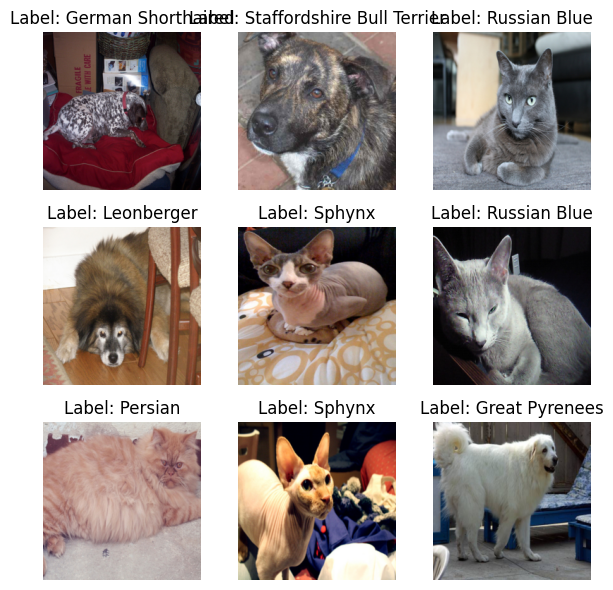

In [9]:
# 학습 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(trainloader)

## 블록 구성하기

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [11]:
class BasicBlock(nn.Module):
    expansion = 1

    # 2 ~ 4번 스테이지의 첫 번째 블록의 1번 conv는 stride=2
    # conv 뒤에 bn이 있으면 관례적으로 bias는 없어도 된다고 함!

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride=stride, padding = 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride=1, padding = 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)  # 새로운 메모리를 만들지 않고 입력텐서를 직접 수정해서 결과를 덮어씀
        self.downsample = downsample

    def forward(self, x):
        identity = x if self.downsample is None else self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = out + identity
        out = self.relu(out)

        return out

In [12]:
class BottleNeck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x if self.downsample is None else self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out = out + identity
        out = self.relu(out)

        return out

In [13]:
class ResNet(nn.Module):

    def __init__(
        self,
        block_type=BasicBlock,
        num_block_list=[3, 4, 6, 3],
        channel_list=[64, 128, 256, 512],
        num_classes=37,
        in_channels=3
    ):

        super().__init__()
        assert len(num_block_list) == len(channel_list), "num_block_list와 channel_list 길이가 같아야 합니다."

        self.block_type = block_type

        # ---- Stem
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ---- Stages
        self.in_channels = 64
        self.layer1 = self._make_stage(num_block=num_block_list[0], out_channels=channel_list[0], stride=1)
        self.layer2 = self._make_stage(num_block=num_block_list[1], out_channels=channel_list[1], stride=2)
        self.layer3 = self._make_stage(num_block=num_block_list[2], out_channels=channel_list[2], stride=2)
        self.layer4 = self._make_stage(num_block=num_block_list[3], out_channels=channel_list[3], stride=2)

        # ---- Heads
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channel_list[3] * self.block_type.expansion, num_classes)

    def _make_stage(self, num_block, out_channels, stride):
        layers = []

        expansion = self.block_type.expansion  # 블록 종류에 따라 채널 수가 블록 내에서 다를 수도 있기 때문

        downsample = None
        block_out_channels = out_channels * expansion
        if stride != 1 or self.in_channels != block_out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, block_out_channels, kernel_size = 1, stride=stride, bias=False),
                nn.BatchNorm2d(block_out_channels)
            )

        # 첫 Block
        layers.append(self.block_type(self.in_channels, out_channels, stride=stride, downsample=downsample))
        self.in_channels = block_out_channels

        # 나머지 Block
        for _ in range(1, num_block):
            layers.append(self.block_type(self.in_channels, out_channels, stride=1, downsample=None))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

In [14]:
def resnet34(num_classes=37, in_channels=3):
    return ResNet(
        block_type=BasicBlock,
        num_block_list=(3, 4, 6, 3),
        channel_list=(64, 128, 256, 512),
        num_classes=num_classes,
        in_channels=in_channels
    )


def resnet50(num_classes=37, in_channels=3):
    return ResNet(
        block_type=BottleNeck,
        num_block_list=(3, 4, 6, 3),
        channel_list=(64, 128, 256, 512),
        num_classes=num_classes,
        in_channels=in_channels
    )

In [15]:
summary(resnet34(num_classes=37), input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 37]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [16]:
summary(resnet50(num_classes=37), input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 37]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─BottleNeck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Sequential: 3-1              [1, 256, 56, 56]          16,896
│    │    └─Conv2d: 3-2                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-3             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-4                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-5                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-6             [1, 64, 56, 56]           12

## Plain-50, Plain-34 만들어보기

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [18]:
class PlainBasicBlock(nn.Module):
    expansion = 1

    # 2 ~ 4번 스테이지의 첫 번째 블록의 1번 conv는 stride=2
    # conv 뒤에 bn이 있으면 관례적으로 bias는 없어도 된다고 함!

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride=stride, padding = 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride=1, padding = 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)  # 새로운 메모리를 만들지 않고 입력텐서를 직접 수정해서 결과를 덮어씀
        # self.downsample = downsample

    def forward(self, x):
        # identity = x if self.downsample is None else self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out

In [19]:
class PlainBottleNeck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        # self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # identity = x if self.downsample is None else self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        # out = out + identity
        out = self.relu(out)

        return out

In [20]:
class Plain(nn.Module):

    def __init__(
        self,
        block_type=PlainBasicBlock,
        num_block_list=[3, 4, 6, 3],
        channel_list=[64, 128, 256, 512],
        num_classes=37,
        in_channels=3
    ):

        super().__init__()
        assert len(num_block_list) == len(channel_list), "num_block_list와 channel_list 길이가 같아야 합니다."

        self.block_type = block_type

        # ---- Stem
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ---- Stages
        self.in_channels = 64
        self.layer1 = self._make_stage(num_block=num_block_list[0], out_channels=channel_list[0], stride=1)
        self.layer2 = self._make_stage(num_block=num_block_list[1], out_channels=channel_list[1], stride=2)
        self.layer3 = self._make_stage(num_block=num_block_list[2], out_channels=channel_list[2], stride=2)
        self.layer4 = self._make_stage(num_block=num_block_list[3], out_channels=channel_list[3], stride=2)

        # ---- Heads
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channel_list[3] * self.block_type.expansion, num_classes)

    def _make_stage(self, num_block, out_channels, stride):
        layers = []

        expansion = self.block_type.expansion  # 블록 종류에 따라 채널 수가 블록 내에서 다를 수도 있기 때문

        # downsample = None
        block_out_channels = out_channels * expansion
        # if stride != 1 or self.in_channels != block_out_channels:
        #     downsample = nn.Sequential(
        #         nn.Conv2d(self.in_channels, block_out_channels, kernel_size = 1, stride=stride, bias=False),
        #         nn.BatchNorm2d(block_out_channels)
        #     )

        # 첫 Block
        layers.append(self.block_type(self.in_channels, out_channels, stride=stride))
        self.in_channels = block_out_channels

        # 나머지 Block
        for _ in range(1, num_block):
            layers.append(self.block_type(self.in_channels, out_channels, stride=1))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

In [21]:
def plain34(num_classes=37, in_channels=3):
    return Plain(
        block_type=PlainBasicBlock,
        num_block_list=(3, 4, 6, 3),
        channel_list=(64, 128, 256, 512),
        num_classes=num_classes,
        in_channels=in_channels
    )


def plain50(num_classes=37, in_channels=3):
    return Plain(
        block_type=PlainBottleNeck,
        num_block_list=(3, 4, 6, 3),
        channel_list=(64, 128, 256, 512),
        num_classes=num_classes,
        in_channels=in_channels
    )

## 모델 학습시키기

### ResNet 모델

In [22]:
import time

In [23]:
BATCH_SIZE = 32
EPOCH = 25

In [24]:
# model 학습 및 검증 함수

def custom_model_train_validation(model):
    import time

    current_time = time.time()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for param in model.parameters():
        param.requires_grad = True
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

    model_train_losses = []
    model_val_accuracy = []
    model_val_losses = []

    for epoch in range(EPOCH):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(trainloader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 100 == 99:
                print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i + 1):.3f}")

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        model_train_losses.append(train_loss)

        print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                loss = criterion(outputs, labels)  # 검증 손실
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(testloader)
        val_acc = 100 * correct / total
        model_val_accuracy.append(val_acc)
        model_val_losses.append(val_loss)

        print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%, Validation Loss: {val_loss:.4f}")

    print("Finished Training")
    print(time.time() - current_time)

    return model_train_losses, model_val_accuracy, model_val_losses

In [25]:
# GPU 확인
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [26]:
# ResNet-34
resnet34_train_losses, resnet34_model_val_accuracy, resnet34_val_losses = custom_model_train_validation(resnet34(num_classes=37))

[1,   100] loss: 3.598
Epoch 1: Train Accuracy: 5.35%
Epoch 1: Validation Accuracy: 6.02%, Validation Loss: 3.7553
[2,   100] loss: 3.298
Epoch 2: Train Accuracy: 10.46%
Epoch 2: Validation Accuracy: 10.98%, Validation Loss: 3.2571
[3,   100] loss: 3.004
Epoch 3: Train Accuracy: 17.74%
Epoch 3: Validation Accuracy: 14.31%, Validation Loss: 3.1503
[4,   100] loss: 2.745
Epoch 4: Train Accuracy: 23.83%
Epoch 4: Validation Accuracy: 14.45%, Validation Loss: 3.1363
[5,   100] loss: 2.415
Epoch 5: Train Accuracy: 30.71%
Epoch 5: Validation Accuracy: 17.42%, Validation Loss: 3.1455
[6,   100] loss: 2.126
Epoch 6: Train Accuracy: 38.26%
Epoch 6: Validation Accuracy: 16.41%, Validation Loss: 3.1283
[7,   100] loss: 1.772
Epoch 7: Train Accuracy: 49.40%
Epoch 7: Validation Accuracy: 14.01%, Validation Loss: 4.3089
[8,   100] loss: 1.382
Epoch 8: Train Accuracy: 60.19%
Epoch 8: Validation Accuracy: 10.96%, Validation Loss: 5.5221
[9,   100] loss: 0.927
Epoch 9: Train Accuracy: 74.57%
Epoch 9: Va

In [27]:
# ResNet-50
resnet50_train_losses, resnet50_model_val_accuracy, resnet50_val_losses = custom_model_train_validation(resnet50(num_classes=37))

[1,   100] loss: 3.749
Epoch 1: Train Accuracy: 3.72%
Epoch 1: Validation Accuracy: 3.16%, Validation Loss: 3.8096
[2,   100] loss: 3.643
Epoch 2: Train Accuracy: 5.03%
Epoch 2: Validation Accuracy: 4.44%, Validation Loss: 3.7405
[3,   100] loss: 3.510
Epoch 3: Train Accuracy: 8.10%
Epoch 3: Validation Accuracy: 7.52%, Validation Loss: 3.6034
[4,   100] loss: 3.362
Epoch 4: Train Accuracy: 10.49%
Epoch 4: Validation Accuracy: 8.50%, Validation Loss: 3.4152
[5,   100] loss: 3.162
Epoch 5: Train Accuracy: 14.18%
Epoch 5: Validation Accuracy: 11.75%, Validation Loss: 3.3278
[6,   100] loss: 3.001
Epoch 6: Train Accuracy: 17.09%
Epoch 6: Validation Accuracy: 13.38%, Validation Loss: 3.3150
[7,   100] loss: 2.778
Epoch 7: Train Accuracy: 22.72%
Epoch 7: Validation Accuracy: 13.76%, Validation Loss: 3.3784
[8,   100] loss: 2.639
Epoch 8: Train Accuracy: 26.22%
Epoch 8: Validation Accuracy: 16.60%, Validation Loss: 3.1359
[9,   100] loss: 2.410
Epoch 9: Train Accuracy: 30.11%
Epoch 9: Validat

In [28]:
# Plain-34
plain34_train_losses, plain34_model_val_accuracy, plain34_val_losses = custom_model_train_validation(plain34(num_classes=37))

[1,   100] loss: 3.604
Epoch 1: Train Accuracy: 3.80%
Epoch 1: Validation Accuracy: 5.10%, Validation Loss: 3.5754
[2,   100] loss: 3.507
Epoch 2: Train Accuracy: 5.68%
Epoch 2: Validation Accuracy: 6.60%, Validation Loss: 3.4843
[3,   100] loss: 3.431
Epoch 3: Train Accuracy: 7.09%
Epoch 3: Validation Accuracy: 6.54%, Validation Loss: 3.4361
[4,   100] loss: 3.349
Epoch 4: Train Accuracy: 8.70%
Epoch 4: Validation Accuracy: 7.55%, Validation Loss: 3.5035
[5,   100] loss: 3.269
Epoch 5: Train Accuracy: 10.14%
Epoch 5: Validation Accuracy: 8.94%, Validation Loss: 3.3153
[6,   100] loss: 3.190
Epoch 6: Train Accuracy: 11.82%
Epoch 6: Validation Accuracy: 10.77%, Validation Loss: 3.2826
[7,   100] loss: 3.115
Epoch 7: Train Accuracy: 13.51%
Epoch 7: Validation Accuracy: 11.09%, Validation Loss: 3.2991
[8,   100] loss: 3.022
Epoch 8: Train Accuracy: 15.54%
Epoch 8: Validation Accuracy: 11.61%, Validation Loss: 3.2068
[9,   100] loss: 2.936
Epoch 9: Train Accuracy: 18.21%
Epoch 9: Validatio

In [29]:
# Plain-50
plain50_train_losses, plain50_model_val_accuracy, plain50_val_losses = custom_model_train_validation(plain50(num_classes=37))

[1,   100] loss: 3.638
Epoch 1: Train Accuracy: 3.26%
Epoch 1: Validation Accuracy: 3.24%, Validation Loss: 3.7488
[2,   100] loss: 3.623
Epoch 2: Train Accuracy: 3.72%
Epoch 2: Validation Accuracy: 4.28%, Validation Loss: 3.6486
[3,   100] loss: 3.586
Epoch 3: Train Accuracy: 4.38%
Epoch 3: Validation Accuracy: 4.88%, Validation Loss: 3.6098
[4,   100] loss: 3.534
Epoch 4: Train Accuracy: 5.52%
Epoch 4: Validation Accuracy: 5.26%, Validation Loss: 3.5762
[5,   100] loss: 3.498
Epoch 5: Train Accuracy: 6.09%
Epoch 5: Validation Accuracy: 6.46%, Validation Loss: 3.5618
[6,   100] loss: 3.436
Epoch 6: Train Accuracy: 6.90%
Epoch 6: Validation Accuracy: 7.14%, Validation Loss: 3.5082
[7,   100] loss: 3.383
Epoch 7: Train Accuracy: 8.18%
Epoch 7: Validation Accuracy: 7.60%, Validation Loss: 3.4830
[8,   100] loss: 3.340
Epoch 8: Train Accuracy: 9.67%
Epoch 8: Validation Accuracy: 8.67%, Validation Loss: 3.3967
[9,   100] loss: 3.283
Epoch 9: Train Accuracy: 10.92%
Epoch 9: Validation Accur

### Training Loss 비교

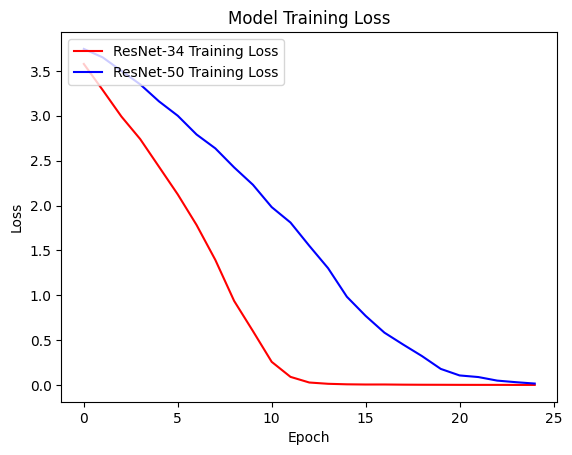

In [32]:
# Training Loss 비교

import matplotlib.pyplot as plt

plt.plot(resnet34_train_losses, 'r', label="ResNet-34 Training Loss")
plt.plot(resnet50_train_losses, 'b', label="ResNet-50 Training Loss")

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### ResNet-34, ResNet-50 Training Loss 비교 및 고찰
- 25epoch 이내에 0으로 수렴하고 있음
- 현재 데이터는 약 학습, 검증 데이터 각각 3500장 정도임
- 데이터의 양이 매우 작아서 발생하는 현상인 것 같음
- 빠른 epoch 이내에 학습 데이터를 완벽히 외운 것으로 보임
- Learning rate의 값이 클 수도 있을 것으로 보임

### 검증 정확도 비교

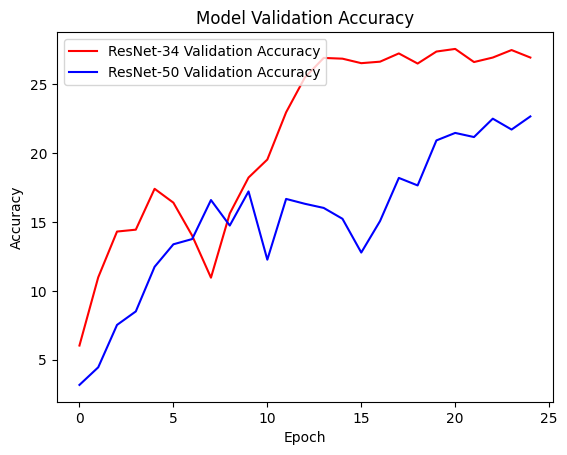

In [33]:
# 검증 정확도 비교

plt.plot(resnet34_model_val_accuracy, 'r', label="ResNet-34 Validation Accuracy")
plt.plot(resnet50_model_val_accuracy, 'b', label="ResNet-50 Validation Accuracy")

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### ResNet-34, ResNet-50 검증 정확도 비교
- Loss는 0으로 수렴했는데 accuracy가 30% 미만이라는 것은 과적합이 된 것 같음
- 이또한 데이터의 양이 적거나 클래스가 많아서 발생하는 문제로 보임
- 또한, 보통은 ResNet-50이 좋아야 하는데 반대로 보임
- 데이터가 작을 때는
    - ResNet-34은 적당한 복잡도로 일반화가 가능하지만
    - ResNet-50은 높은 복잡도로는 일반화가 어려움
- 결론은 지금 데이터 규모에서는 ResNet-50은 과한 모델인 것 같음
- 데이터의 양을 증강시키기 위해 augmentation 기법을 써보는 것도 좋은 방법일듯

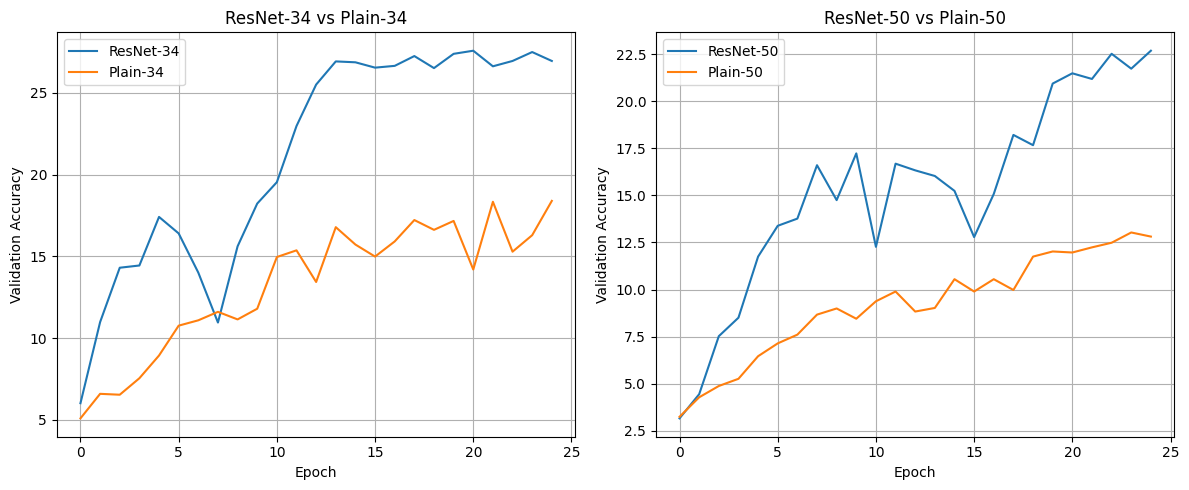

In [34]:
### ResNet-34 vs Plain-34 검증 정확도 비교
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1) ResNet-34 vs Plain-34
axes[0].plot(resnet34_model_val_accuracy, label="ResNet-34")
axes[0].plot(plain34_model_val_accuracy, label="Plain-34")
axes[0].set_title("ResNet-34 vs Plain-34")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Validation Accuracy")
axes[0].legend()
axes[0].grid(True)

# 2) ResNet-50 vs Plain-50
axes[1].plot(resnet50_model_val_accuracy, label="ResNet-50")
axes[1].plot(plain50_model_val_accuracy, label="Plain-50")
axes[1].set_title("ResNet-50 vs Plain-50")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Validation Accuracy")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

### ResNet 모델과 Plain 모델의 Validation Accuracy 비교
- 두 경우 모두 plain 모델보다 검증 정확도가 높은 것 확인
- ResNet-34 VS Plain-34의 경우 6~7epoch 즈음 갑자기 튀는 경우가 있었는데, 이는 learning rate, 데이터 규모 이슈로 보임
- Residual Connection이 실질적으로 Degradation Problem의 해결에 효과가 있는 것으로 판단됨

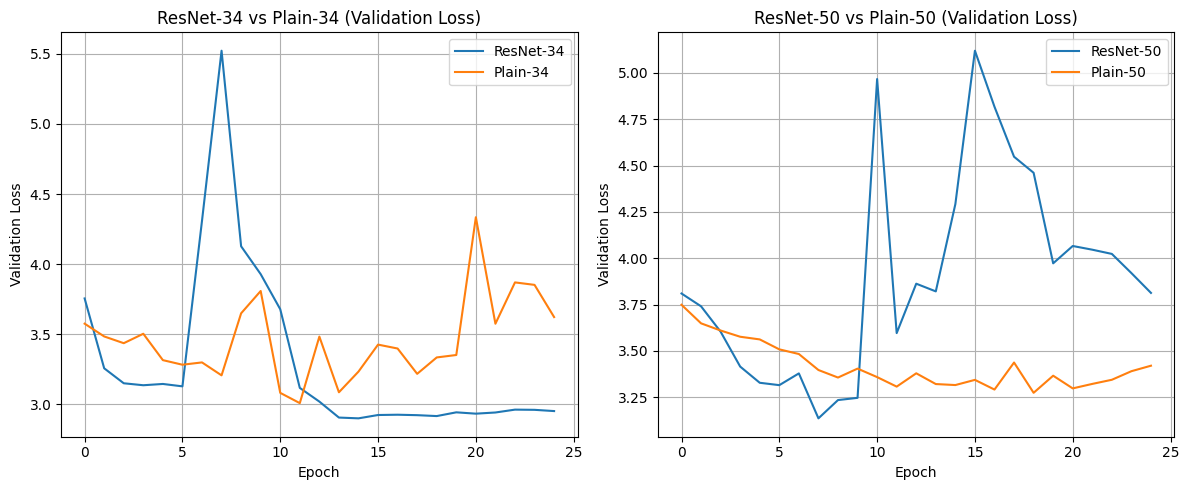

In [35]:
### ResNet-34 vs Plain-34 검증 손실 비교
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1) ResNet-34 vs Plain-34 (Validation Loss)
axes[0].plot(resnet34_val_losses, label="ResNet-34")
axes[0].plot(plain34_val_losses, label="Plain-34")
axes[0].set_title("ResNet-34 vs Plain-34 (Validation Loss)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Validation Loss")
axes[0].legend()
axes[0].grid(True)

# 2) ResNet-50 vs Plain-50 (Validation Loss)
axes[1].plot(resnet50_val_losses, label="ResNet-50")
axes[1].plot(plain50_val_losses, label="Plain-50")
axes[1].set_title("ResNet-50 vs Plain-50 (Validation Loss)")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Validation Loss")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


### ResNet, Plain 모델의 Validation Loss 비교
- ResNet34 모델의 loss가 6~7epoch 즈음 튀는 현상이 있지만 그 이후로는 안정적으로 수렴하는 것 확인
- ResNet50 모델의 경우 안정적인 학습이 이루어지지 않는 것 같음
- 데이터 대비 모델 규모가 너무 커서 그런 것 같음